In [6]:
import numpy as np

# Path to your CSV file
path_train = 'data/train_data.npy'
path_test = 'data/test_data.npy'
path_test_label = 'data/test_labels.npy'

# Read the CSV file into a DataFrame
train = np.load(path_train)
test = np.load(path_test)
test_labels = np.load(path_test_label)

In [ ]:
# ideas
# try summing
# leave predicted anomalies out of the moving average

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot_distribution(df):
    # Number of columns
    num_columns = len(df.columns)
    
    # Calculate the number of rows and columns for the subplots
    num_rows = math.ceil(num_columns / 3)
    num_cols = min(num_columns, 3)
    
    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))
    
    # Flatten the axes array if there's more than one plot
    axes = axes.flatten() if num_columns > 1 else [axes]
    
    # Plot data distribution for each column
    for i, column in enumerate(df.columns):
        axes[i].hist(df[column], bins=10, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
    
    # Remove any unused axes
    for ax in axes[num_columns:]:
        ax.remove()
    
    plt.tight_layout()
    plt.show()

In [22]:
import numpy as np
import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Define the custom estimator class
class MovingAverageAnomalyDetector(BaseEstimator):
    diffs = []
    def __init__(self, m=100, threshold=2.0):
        self.m = m  # Moving average window size
        self.threshold = threshold  # Anomaly detection threshold

    def fit(self, X, y=None):
        # Fit method is required by sklearn but we don't need to do anything for this specific case
        return self

    def predict(self, X):
        # Initialize an array to store detected anomalies
        detected_anomalies = np.zeros(len(X))

        # Loop over data, starting from index m
        for i in range(self.m, len(X)):
            # Calculate the moving average for each column (feature) for the last m values
            moving_avg = np.mean(X[i-self.m:i], axis=0)

            # Calculate the difference between the current value and moving average for each column
            diff = np.abs(X[i] - moving_avg)
            self.diffs.append(diff)
            # If any of the differences exceed the threshold, mark as anomaly
            if np.any(diff > self.threshold):
                detected_anomalies[i] = 1  # Mark as anomaly

        return detected_anomalies

    def score(self, X, y):
        # Predict anomalies
        predicted_anomalies = self.predict(X)
        
        # Calculate and return F1 score
        return f1_score(y, predicted_anomalies)

    def get_params(self, deep=True):
        """ Get hyperparameters of the model """
        return {'m': self.m, 'threshold': self.threshold}

    def set_params(self, **params):
        """ Set hyperparameters of the model """
        for param, value in params.items():
            setattr(self, param, value)
        return self

data = test
labels = test_labels

# Hyperparameter grid for tuning
param_grid = {
    'm': [300, 500, 750],  # Test different window sizes
    'threshold': [1e-7 ,1e-5]  # Test different threshold values
}

# Initialize the model and grid search
model = MovingAverageAnomalyDetector()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', verbose=1)

# Fit the model to the data and search for the best parameters
grid_search.fit(data, labels)

# Get the best parameters from the grid search
print("Best Parameters: ", grid_search.best_params_)

# Get the best F1 score from the grid search
best_f1_score = grid_search.best_score_
print(f"Best F1 Score: {best_f1_score}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:  {'m': 750, 'threshold': 1e-07}
Best F1 Score: 0.203462333505483


In [ ]:
'''
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters:  {'m': 100, 'threshold': 0.001}
Best F1 Score: 0.19735214568879156

param_grid = {
    'm': [10, 50, 100],  # Test different window sizes
    'threshold': [0.001, 0.01, 0.02, 0.021]  # Test different threshold values
}
'''

'''

'''


In [19]:
print(min(model.diffs[0]))
print(max(model.diffs[0]))

0.0
0.022963648648893442


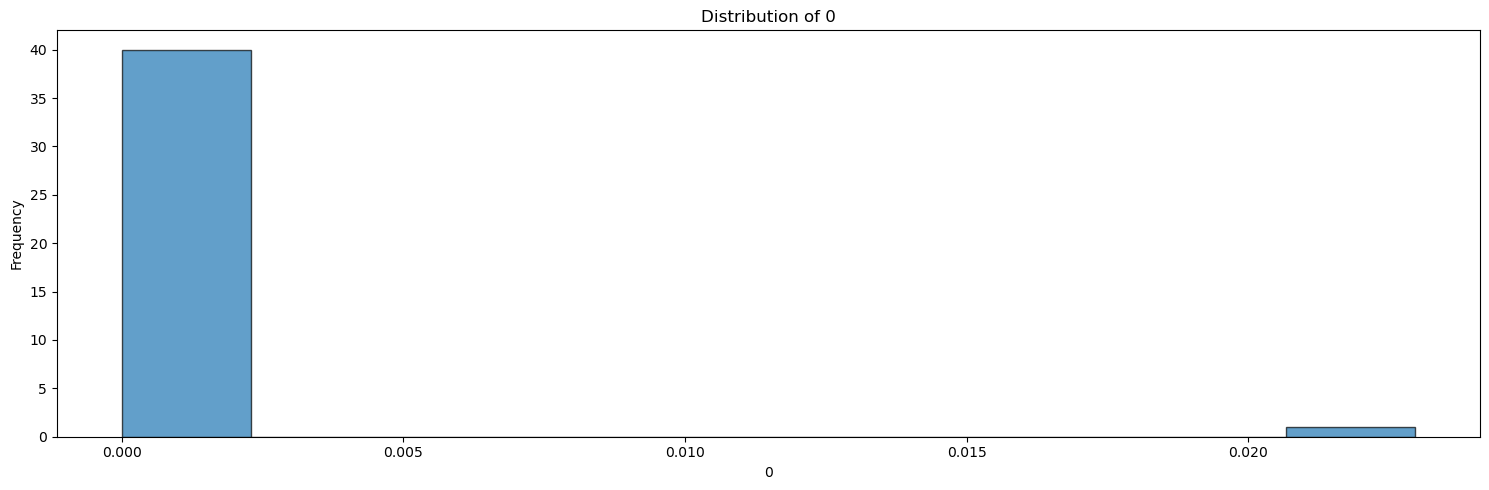

In [18]:
plot_distribution(pd.DataFrame(model.diffs[0]))

In [7]:
import numpy as np
import tqdm
from sklearn.base import BaseEstimator
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Define the custom estimator class
class MovingAverageAnomalyDetectorSum(BaseEstimator):
    diffs = []
    total_diffs = []
    def __init__(self, m=100, threshold=2.0):
        self.m = m  # Moving average window size
        self.threshold = threshold  # Anomaly detection threshold

    def fit(self, X, y=None):
        # Fit method is required by sklearn but we don't need to do anything for this specific case
        return self

    def predict(self, X):
        # Initialize an array to store detected anomalies
        detected_anomalies = np.zeros(len(X))

        # Loop over data, starting from index m
        for i in range(self.m, len(X)):
            # Calculate the moving average for each column (feature) for the last m values
            moving_avg = np.mean(X[i-self.m:i], axis=0)

            # Calculate the difference between the current value and moving average for each column
            diff = np.abs(X[i] - moving_avg)
            total_diff = np.sum(X[i])
            self.diffs.append(diff)
            self.total_diffs.append(total_diff)
            
            # If sum exceeds threshold mark as anomaly
            if total_diff > self.threshold:
                detected_anomalies[i] = 1  # Mark as anomaly

        return detected_anomalies

    def score(self, X, y):
        # Predict anomalies
        predicted_anomalies = self.predict(X)
        
        # Calculate and return F1 score
        return f1_score(y, predicted_anomalies)

    def get_params(self, deep=True):
        """ Get hyperparameters of the model """
        return {'m': self.m, 'threshold': self.threshold}

    def set_params(self, **params):
        """ Set hyperparameters of the model """
        for param, value in params.items():
            setattr(self, param, value)
        return self

In [8]:
data = test
labels = test_labels

In [ ]:
model = MovingAverageAnomalyDetectorSum()

In [17]:
# Hyperparameter grid for tuning
param_grid = {
    'm': [100],  # Test different window sizes
    'threshold': [1e-3, 1e-1, 0.5 ,1, 3, 5, 10]  # Test different threshold values
}

param_grid_test = {
    'm': [10],  # Test different window sizes
    'threshold': [1]  # Test different threshold values
}

# Initialize the model and grid search
model = MovingAverageAnomalyDetectorSum()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='f1', verbose=1)

# Fit the model to the data and search for the best parameters
grid_search.fit(data, labels)

# Get the best parameters from the grid search
print("Best Parameters: ", grid_search.best_params_)

# Get the best F1 score from the grid search
best_f1_score = grid_search.best_score_
print(f"Best F1 Score: {best_f1_score}")

Fitting 3 folds for each of 7 candidates, totalling 21 fits
Best Parameters:  {'m': 100, 'threshold': 0.001}
Best F1 Score: 0.20272024003282305


In [10]:
model.total_diffs

[28.29955362250907,
 28.30033524792829,
 28.292726018147793,
 28.28496590738614,
 28.289399918703005,
 28.281285614621694,
 28.28508859546092,
 28.280360031606325,
 28.270298223181147,
 28.265981644714124,
 28.25814966256486,
 28.253905258233065,
 28.251104844080356,
 28.23935300778092,
 28.23651056214333,
 28.22783451310617,
 28.220167438924044,
 28.217331305658334,
 28.23796492141247,
 28.25849304438598,
 28.273834295707054,
 28.304596300168818,
 28.32377510305109,
 28.3209838176709,
 28.31506285447636,
 28.300517689316163,
 28.290215943964355,
 28.29372859996142,
 28.296735879645915,
 28.297065961716104,
 28.29308427838439,
 28.28677658485568,
 28.275838642978016,
 28.258495569618432,
 28.251960691400864,
 28.2381010183825,
 28.238822499581556,
 28.247800410219305,
 28.253685894746717,
 28.25172426852121,
 28.245702319383042,
 28.24078654175208,
 28.230773935302956,
 28.234164085932587,
 28.2538369016752,
 28.26237215796793,
 28.278687036577587,
 28.299901999161108,
 28.306792458717

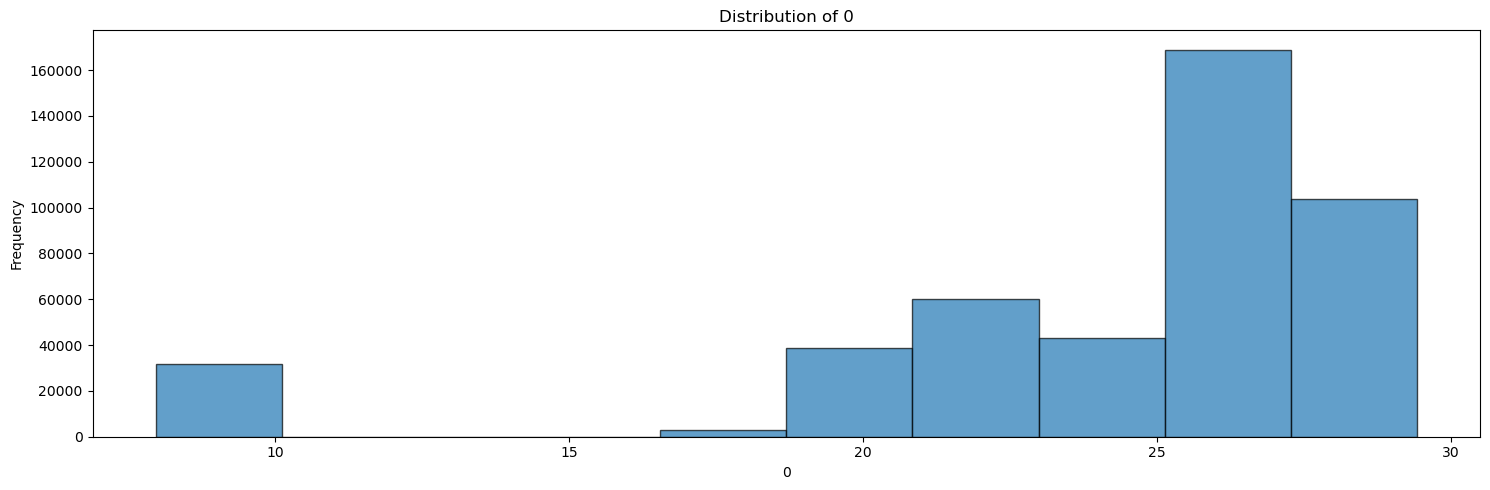

In [12]:
plot_distribution(pd.DataFrame(model.total_diffs))

In [16]:
np.sum(model.total_diffs) / np.mean(model.total_diffs)

4046841.0